In [1]:
import os
import cv2
import numpy as np
from CellClass import evaluate_segmentation as eval
from natsort import natsorted
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import pandas as pd

base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata"
files = natsorted([x for x in os.listdir(base) if ".png" in x])

for file in files:
    if "SIMON" in file:
        eval._process_illustrator_output(os.path.join(base, file), os.path.join(base,"simon"))
    elif "FIKRET" in file:
        eval._process_illustrator_output(os.path.join(base, file), os.path.join(base,"fikret"))
        

  0%|          | 0/5 [00:00<?, ?it/s]

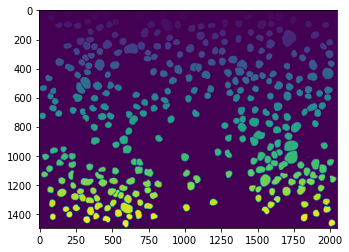

 20%|██        | 1/5 [00:03<00:15,  3.86s/it]

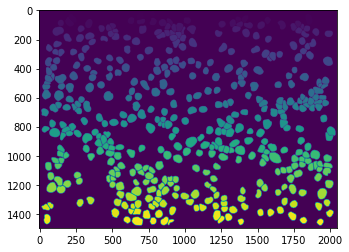

 40%|████      | 2/5 [00:09<00:13,  4.62s/it]

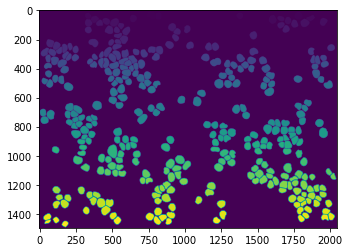

 60%|██████    | 3/5 [00:13<00:08,  4.34s/it]

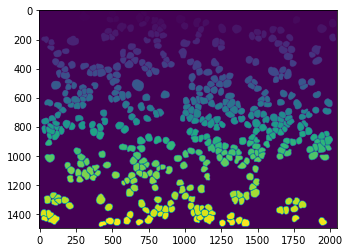

 80%|████████  | 4/5 [00:18<00:04,  4.70s/it]

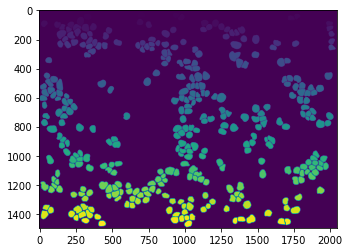

  0%|          | 0/1 [00:00<?, ?it/s]

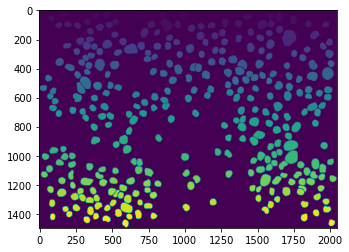

100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


In [2]:
bases = ["/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/simon", "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/fikret"]

for base, observer in zip(bases, ["observer0", "observer1"]):
    files = natsorted([x for x in os.listdir(base) if ".png" in x])

    samples = []
    for file in tqdm(files):
        sample = file.split("-")[0]
        im = eval.remove_boarder(eval.load_segmentation(os.path.join(base, file)))
        samples.append({"name": sample, "im": im})
        plt.imshow(im); plt.show()

    locals()[observer] = pd.DataFrame(samples)

In [3]:
base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/testdata/dapi"
files = natsorted([x for x in os.listdir(base) if ".tif" in x.lower()])

samples = []
for file in tqdm(files):
    sample = file.split(".")[0]
    im = cv2.imread(os.path.join(base, file), 0)
    samples.append({"name": sample, "im": im})

locals()["dapi"] = pd.DataFrame(samples)

100%|██████████| 5/5 [00:00<00:00, 10.98it/s]


In [9]:
from CellClass.Segment import Segmentation

CP = Segmentation("deepcell")

In [10]:
dfs = []
for _, row in dapi.iterrows():
    _, mask, o = CP(row.im, return_outline=True, image_mpp=0.45)
    mask = eval.remove_boarder(mask)
    dfs.append({"name": row["name"], "dapi": row.im, "im": mask})
    

/home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


In [11]:
predictions = pd.DataFrame(dfs)

DAPI_0


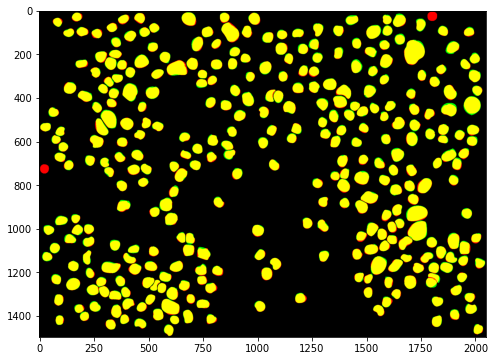

100%|██████████| 330/330 [00:04<00:00, 72.68it/s]


False Positives: 0
False Negatives: 2


100%|██████████| 328/328 [00:31<00:00, 10.50it/s]


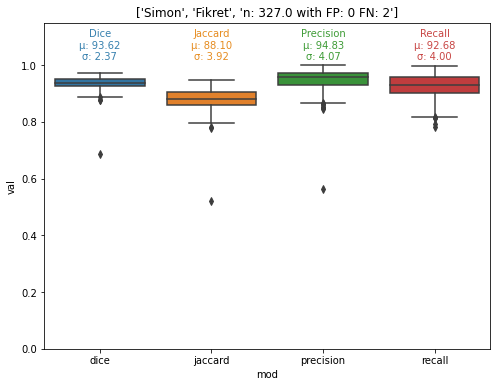

DAPI_0


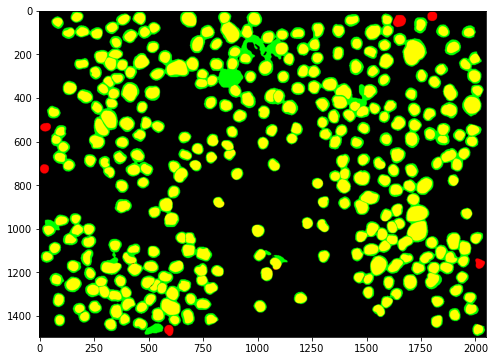

100%|██████████| 330/330 [00:04<00:00, 69.23it/s]


False Positives: 7
False Negatives: 6


100%|██████████| 324/324 [00:29<00:00, 10.83it/s]


DAPI_1


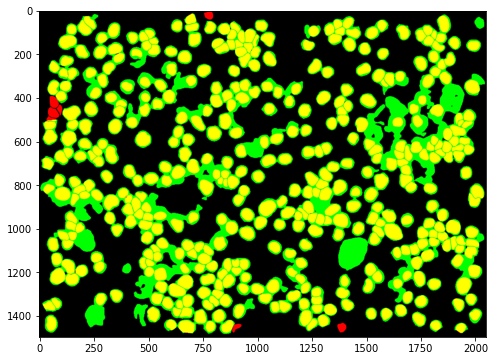

100%|██████████| 444/444 [00:07<00:00, 58.97it/s]


False Positives: 42
False Negatives: 6


100%|██████████| 438/438 [00:41<00:00, 10.65it/s]


DAPI_2


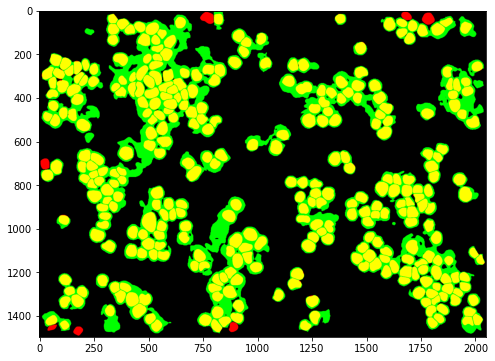

100%|██████████| 348/348 [00:05<00:00, 65.55it/s]


False Positives: 23
False Negatives: 7


100%|██████████| 340/340 [00:35<00:00,  9.68it/s]


DAPI_3


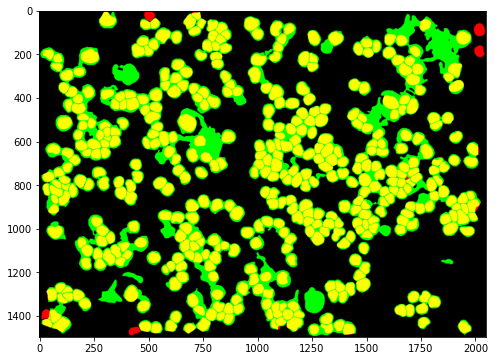

100%|██████████| 452/452 [00:07<00:00, 58.20it/s]


False Positives: 19
False Negatives: 5


  1%|▏         | 6/446 [00:00<00:41, 10.58it/s]/home/simon_g/src/MICCAI/CellClass/evaluate_segmentation.py:91: RuntimeWarning: invalid value encountered in long_scalars
  recall = TP/(TP+FN)
100%|██████████| 446/446 [00:48<00:00,  9.23it/s]


DAPI_4


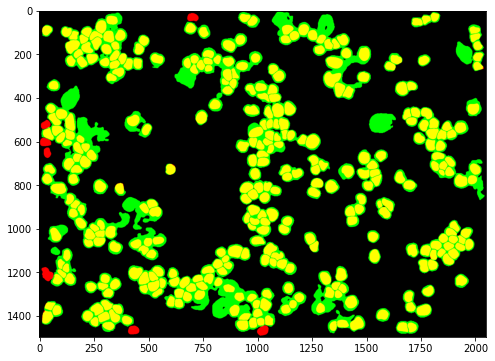

100%|██████████| 357/357 [00:06<00:00, 57.75it/s]


False Positives: 19
False Negatives: 7


100%|██████████| 350/350 [00:37<00:00,  9.26it/s]


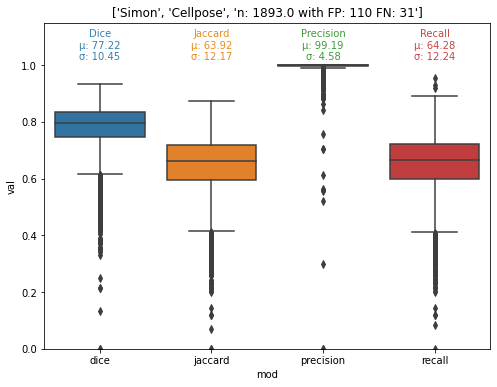

DAPI_0


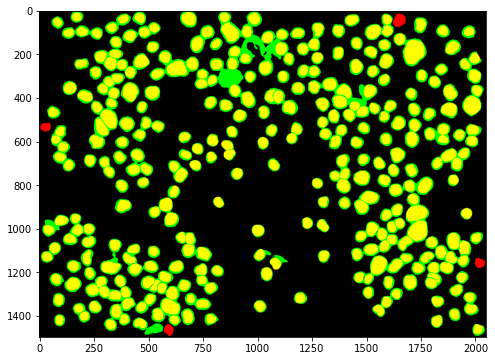

100%|██████████| 335/335 [00:05<00:00, 56.98it/s]


False Positives: 7
False Negatives: 4


100%|██████████| 325/325 [00:32<00:00,  9.88it/s]


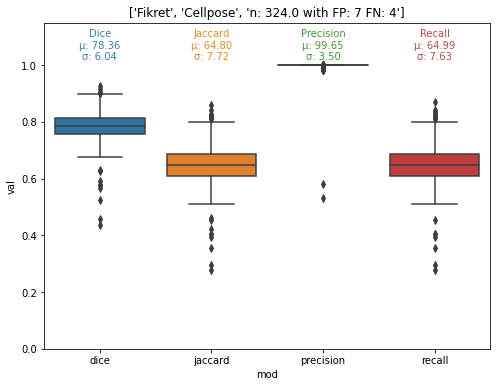

In [12]:
import importlib
importlib.reload(eval)

def compare_segmentations(df0, df1, title):

    rets = []
    fps = 0
    fns = 0
    for _, row in df0.iterrows():
        if any(df1['name'].str.contains(row["name"])):
            print(row["name"])
            seg0 = np.copy(row["im"])
            seg1 = np.copy(df1[df1["name"]==row["name"]].im.item())
            plt.imshow(eval.additive_blend(seg0, seg1));plt.show()
            ret, fp, fn = eval.compare_segmentations(seg0, seg1)
            rets.extend(ret)
            fps += fp
            fns += fn
            
    df = pd.DataFrame(rets)
    d = []
    for n in natsorted(df["mod"].unique()):
        tmp = df[df["mod"] == n]
        d.append({
            "mean": tmp.val.mean(),
            "std": tmp.val.std(),
            "measure": n,
            })
                
    plt.rcParams["figure.figsize"] = 8,6
    ax = sb.boxplot(x="mod", y="val", data=df)
    ax.set_ylim(0, 1.15)

    for info, n, c, val in zip(d, np.linspace(0,3,4), ["#3680AE", "#E68C20", "#3F9C37", "#C84644"], [f"Dice", f"Jaccard",f"Precision",f"Recall"]):
        plt.text(n, 1.07, f"{val}\nµ: {info['mean']*100:.2f}\nσ: {info['std']*100:.2f}", ha="center", va="center", c=c)
       
    ax.set_title([*title, f"n: {len(rets)/4} with FP: {fps} FN: {fns}"])  
    plt.show()   
                
compare_segmentations(observer0, observer1, ["Simon", "Fikret"])  
compare_segmentations(observer0, predictions, ["Simon", "Cellpose"])  
compare_segmentations(observer1, predictions, ["Fikret", "Cellpose"])  

